In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_parquet('fully_combined.parquet')

In [3]:
df.head()

,locationid,transit_timestamp,ridership
0,2.0,2022-02-06 15:00:00,1.0
1,2.0,2022-02-16 23:00:00,1.0
2,2.0,2022-02-23 08:00:00,1.0
3,2.0,2022-02-23 19:00:00,4.0
4,2.0,2022-03-22 10:00:00,1.0


In [4]:
df.tail()

,locationid,transit_timestamp,ridership
3857551,263.0,2024-05-30 19:00:00,985.0
3857552,263.0,2024-05-30 20:00:00,573.0
3857553,263.0,2024-05-30 21:00:00,452.0
3857554,263.0,2024-05-30 22:00:00,370.0
3857555,263.0,2024-05-30 23:00:00,226.0


In [5]:
# Check just how many rows:
print("number of rows: ", df.shape[0])

number of rows:  3857556


In [6]:
#Print the number of duplicates, without the original rows that were duplicated
print('Number of duplicate (excluding first) rows in the table is: ', df.duplicated().sum())

Number of duplicate (excluding first) rows in the table is:  0


In [7]:
df.isnull().sum()

locationid           0
transit_timestamp    0
ridership            0
dtype: int64

In [8]:
# Check the data types in each column as assigned by default.
df.dtypes

locationid                  float64
transit_timestamp    datetime64[ns]
ridership                   float64
dtype: object

In [9]:
categorical_columns = df[['locationid']].columns

# Convert data type to int for these columns - gets rid of decimal place
for column in categorical_columns:
    df[column] = df[column].astype('int')
    

integer_columns = df[['ridership']].columns

# Convert data type to object for these columns
for column in integer_columns:
    df[column] = df[column].astype('int')

In [10]:
# Check the data types in each column as assigned by default.
df.dtypes

locationid                    int64
transit_timestamp    datetime64[ns]
ridership                     int64
dtype: object

In [11]:
categorical_columns = df[['locationid']].columns

# Convert data type to category for these columns
for column in categorical_columns:
    df[column] = df[column].astype('category')

In [12]:
df.head()

,locationid,transit_timestamp,ridership
0,2,2022-02-06 15:00:00,1
1,2,2022-02-16 23:00:00,1
2,2,2022-02-23 08:00:00,1
3,2,2022-02-23 19:00:00,4
4,2,2022-03-22 10:00:00,1


In [13]:
# Print table with categorical statistics
df.select_dtypes(['category']).describe().T

,count,unique,top,freq
locationid,3857556,260,132,20429


In [14]:
# Print table with continuous statistics
df.select_dtypes(include=['int64']).describe().T

,count,mean,std,min,25%,50%,75%,max
ridership,3857556.0,1093.939583,2699.192049,0.0,42.0,259.0,968.0,74080.0


In [15]:
# Check if all datetime values are rounded to the nearest hour
all_rounded = df['transit_timestamp'].apply(lambda x: x.minute == 0 and x.second == 0)
    
if all_rounded.all():
    print("All datetime values are rounded to the nearest hour.")
else:
    print("All datetime values are not rounded to the nearest hour.")
    

All datetime values are rounded to the nearest hour.


In [16]:
# Identify duplicate combinations of locationid and transit_timestamp
duplicates = df.duplicated(subset=['locationid', 'transit_timestamp'], keep=False)
    
if duplicates.any():
    print("There are duplicate rows with the same locationid and transit_timestamp.")
        
    # Show the duplicate rows
    duplicate_rows = df[duplicates].sort_values(by=['locationid', 'transit_timestamp'])
    print("Duplicate rows:")
    print(duplicate_rows)
        
    # Number of duplicate rows
    duplicate_count = duplicate_rows.shape[0]
    print(f"Number of duplicate rows: {duplicate_count}")
else:
    print("There are no duplicate rows with the same locationid and transit_timestamp.")

There are no duplicate rows with the same locationid and transit_timestamp.


In [17]:
# Filter and print rows for a specific transit_timestamp
specific_timestamp = pd.Timestamp('2022-02-23 17:00:00')  
specific_locationid = 7
filtered_rows = df[(df['transit_timestamp'] == specific_timestamp) & (df['locationid'] == specific_locationid)]
print(f"Rows with transit_timestamp = {specific_timestamp} and locationid = {specific_locationid}:")
print(filtered_rows)

Rows with transit_timestamp = 2022-02-23 17:00:00 and locationid = 7:
      locationid   transit_timestamp  ridership
39154          7 2022-02-23 17:00:00       2101


In [18]:
# Find the minimum and maximum ridership values
print("Minimum ridership: ", df['ridership'].min())
print("Maximum ridership: ", df['ridership'].max())

max_ridership = df['ridership'].max()

Minimum ridership:  0
Maximum ridership:  74080


In [19]:
# Count the number of rows in each specified range
#ranges = {
    #'Quiet': (0, 999),
    #'Not Too Busy': (1000, 4999),
    #'A Little Busy': (5000, 9999),
    #'Busy': (10000, 19999),
    #'Very Busy': (20000, 49999),
    #'Extremely Busy': (50000, 74080)
    #}

# Define ranges using quantiles to get more balanced distribution
quantiles = df['ridership'].quantile([0, 0.2, 0.4, 0.6, 0.8, 0.99]).values

# Max ridership is an outlier and without the following code was the only value in extremely busy
quantiles = list(quantiles) + [max_ridership]
    
# Convert quantile values to integers to get rid of decimal places
quantiles = [int(q) for q in quantiles]

# Define ranges based on quantiles
# minus 1 at the end of each quantile to avoid overlap, e.g. Quiet was 0-23 and not too busy was 23-143, meaning both contained 23
ranges = {
    'Quiet': (quantiles[0], quantiles[1]-1),
    'Not Too Busy': (quantiles[1], quantiles[2]-1),
    'A Little Busy': (quantiles[2], quantiles[3]-1),
    'Busy': (quantiles[3], quantiles[4]-1),
    'Very Busy': (quantiles[4], quantiles[5]-1),
    'Extremely Busy': (quantiles[5], quantiles[6])
    }
    
range_counts = {}
for label, (lower, upper) in ranges.items():
    count = ((df['ridership'] >= lower) & (df['ridership'] <= upper)).sum()
    range_counts[label] = count
    
print("Number of entries in each ridership range:")
for label, count in range_counts.items():
    print(f"{label}: {count}")
    
print("\n")    
print("Ranges used for each category:")
for label, (lower, upper) in ranges.items():
    print(f"{label}: {lower} - {upper}")

Number of entries in each ridership range:
Quiet: 766965
Not Too Busy: 772710
A Little Busy: 774166
Busy: 771704
Very Busy: 733433
Extremely Busy: 38578


Ranges used for each category:
Quiet: 0 - 22
Not Too Busy: 23 - 142
A Little Busy: 143 - 444
Busy: 445 - 1286
Very Busy: 1287 - 13404
Extremely Busy: 13405 - 74080


In [20]:
# Assign busyness label based on ridership value
def assign_label(ridership):
    if 0 <= ridership <= 22:
        return 'Quiet'
    elif 23 <= ridership <= 142:
        return 'Not Too Busy'
    elif 143 <= ridership <= 444:
        return 'A Little Busy'
    elif 445 <= ridership <= 1286:
        return 'Busy'
    elif 1287 <= ridership <= 13404:
        return 'Very Busy'
    elif 13405 <= ridership <= 74080:
        return 'Extremely Busy'
    else:
        raise ValueError(f"Ridership value {ridership} cannot be assigned a category.")

# Create new column 'busyness' assigning label to each ridership value
try:
    df['busyness'] = df['ridership'].apply(assign_label)
    print("Label assignment successful.")
except ValueError as e:
    print(f"Error: {str(e)}")

# Display the updated DataFrame with the new column
print(df.tail(30))


Label assignment successful.
        locationid   transit_timestamp  ridership       busyness
3857526        263 2024-05-29 18:00:00       1456      Very Busy
3857527        263 2024-05-29 19:00:00        913           Busy
3857528        263 2024-05-29 20:00:00        588           Busy
3857529        263 2024-05-29 21:00:00        439  A Little Busy
3857530        263 2024-05-29 22:00:00        337  A Little Busy
3857531        263 2024-05-29 23:00:00        197  A Little Busy
3857532        263 2024-05-30 00:00:00         60   Not Too Busy
3857533        263 2024-05-30 01:00:00         12          Quiet
3857534        263 2024-05-30 02:00:00          5          Quiet
3857535        263 2024-05-30 03:00:00          8          Quiet
3857536        263 2024-05-30 04:00:00         18          Quiet
3857537        263 2024-05-30 05:00:00         93   Not Too Busy
3857538        263 2024-05-30 06:00:00        383  A Little Busy
3857539        263 2024-05-30 07:00:00       1419      Very B

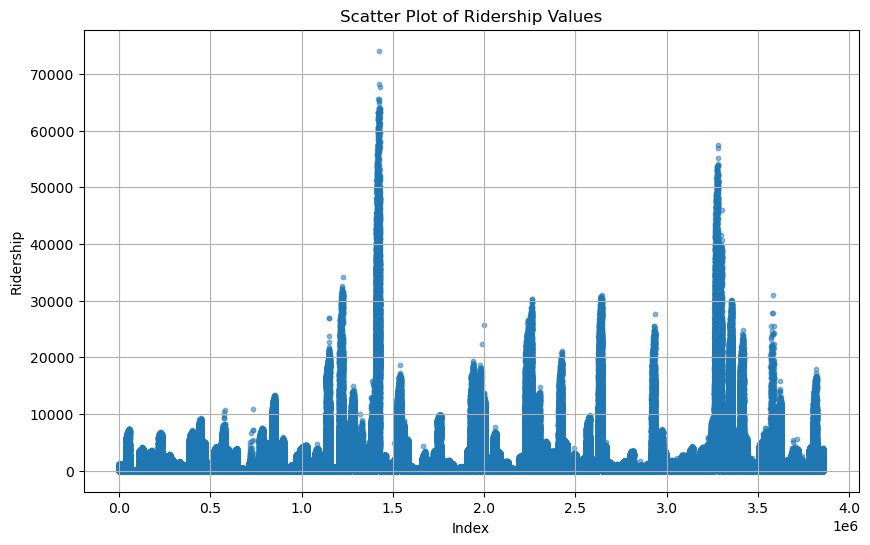

In [21]:
plt.figure(figsize=(10, 6))

# Plot ridership against index
plt.scatter(df.index, df['ridership'], s=10, alpha=0.5)
plt.title('Scatter Plot of Ridership Values')
plt.xlabel('Index')
plt.ylabel('Ridership')
plt.grid(True)
plt.show()

In [22]:
# Check for irregular cardinality & permitted values in categorical features.
print("Unique values for:\nLocationid:", pd.unique(df["locationid"].ravel()), "\n", "\n")
print("Busyness:", pd.unique(df["busyness"].ravel()))

Unique values for:
Locationid: [2, 3, 4, 5, 6, ..., 259, 260, 261, 262, 263]
Length: 260
Categories (260, int64): [2, 3, 4, 5, ..., 260, 261, 262, 263] 
 

Busyness: ['Quiet' 'Not Too Busy' 'A Little Busy' 'Busy' 'Very Busy'
 'Extremely Busy']


In [23]:
# Write the dataframe to a csv file
df.to_csv('combined_indexed.csv', index=False)

# Reading from updated csv file, into a data frame
df = pd.read_csv('combined_indexed.csv')

In [33]:
# Reading from updated csv file, into a data frame
df = pd.read_csv('combined_indexed.csv')

In [34]:
# Check just how many rows:
print("number of rows: ", df.shape[0])

# Check just how many columns/features:
print("number of features: ", df.shape[1])

number of rows:  3857556
number of features:  4


In [35]:
# Check the data types in each column as assigned by default.
df.dtypes

locationid            int64
transit_timestamp    object
ridership             int64
busyness             object
dtype: object

In [36]:
integer_columns = df[['ridership', 'locationid']].columns

# Convert data type to object for these columns
for column in integer_columns:
    df[column] = df[column].astype('int')

In [37]:
categorical_columns = df[['locationid', 'busyness']].columns

# Convert data type to category for these columns
for column in categorical_columns:
    df[column] = df[column].astype('category')
    

In [38]:
# Convert data type to datetime
df['transit_timestamp'] = df['transit_timestamp'].astype('datetime64[ns]')
    


In [39]:
# Check the data types in each column as assigned by default.
df.dtypes

locationid                 category
transit_timestamp    datetime64[ns]
ridership                     int64
busyness                   category
dtype: object

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Define user input features (locationid and transit_timestamp) and target (ridership)
X = df[['locationid', 'transit_timestamp']].copy() # Avoid indexing error
y = df['ridership']

In [ ]:
# Extract hour from transit_timestamp
X['hour'] = X['transit_timestamp'].dt.hour

# Drop the original transit_timestamp column
X = X.drop('transit_timestamp', axis=1)

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize and train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

In [ ]:
# Predict busyness based on input
locationid = 150
transit_timestamp = pd.to_datetime('2024-07-30 23:00:00')
hour = transit_timestamp.hour

# Create a DataFrame with the input values
input_data = pd.DataFrame({'locationid': [locationid], 'hour': [hour]})

predicted_ridership = model.predict(input_data)
predicted_ridership = predicted_ridership[0] 

# Assign busyness label based on predicted ridership
predicted_busyness = assign_label(predicted_ridership)
print(f'Predicted Busyness: {predicted_busyness}')


In [30]:
# Classification model code
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

In [40]:
# Load data
#df = pd.read_csv('combined_indexed.csv')

# Extract hour from transit_timestamp
df['hour'] = df['transit_timestamp'].dt.hour

In [41]:
# Define features
X = df[['locationid', 'hour']].copy()  # Avoid indexing error
y = df['busyness']

In [42]:
# Make busyness numeric
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)


In [44]:
# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [45]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


/Users/muireannoconnor/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/muireannoconnor/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
                 precision    recall  f1-score   support

 A Little Busy       0.24      0.16      0.19    232037
          Busy       0.23      0.21      0.22    231319
Extremely Busy       0.00      0.00      0.00     11719
  Not Too Busy       0.29      0.37      0.33    231646
         Quiet       0.23      0.26      0.24    230439
     Very Busy       0.21      0.22      0.21    220107

      accuracy                           0.24   1157267
     macro avg       0.20      0.20      0.20   1157267
  weighted avg       0.24      0.24      0.24   1157267

Accuracy Score: 0.2419692257707167


/Users/muireannoconnor/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
# Predict busyness based on frontend input
locationid = 150
transit_timestamp = pd.to_datetime('2024-07-30 23:00:00')
hour = transit_timestamp.hour

# Create a DataFrame with the input values
input_data = pd.DataFrame({'locationid': [locationid], 'hour': [hour]})

# Make prediction
predicted_busyness_encoded = model.predict(input_data)
predicted_busyness = label_encoder.inverse_transform(predicted_busyness_encoded)

print(f'Predicted Busyness: {predicted_busyness[0]}')


Predicted Busyness: Very Busy
